In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

import torch
import torch.distributions as dist 

import zuko

In [2]:
def forward_function(bulk_velocity, offset):    
    # since we know the source is at x=0, we can calculate the distance to the receiver directly by using pythagoras theorem
    return torch.sqrt(0.5**2 + offset**2) / bulk_velocity

In [3]:
n_prior = int(1e6)

bulk_velocity_prior = dist.Independent(dist.Normal(torch.tensor([4.5,]), torch.tensor([0.5,])), 1)
bulk_velocity_prior_samples = bulk_velocity_prior.sample([n_prior])

In [4]:
def data_likelihood(samples, design, design_dicts):

    torch.manual_seed(0)
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor([0.1])), 1)
    
    return data_likelihood

In [5]:
n_design_points = 10
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(100, 900, n_design_points)

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function, 'cost': 1.0}


In [6]:
def constructor_1to1_design(self, name_list, n_samples):
    
    name_list = list(dict.fromkeys(name_list)) # remove duplicates 
    # list(set(name_list)) destroys the order of the list
    design_dicts_list = [self.design_dicts[n] for n in name_list]
        
    data = torch.zeros((n_samples, len(name_list), 1))
                
    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](self.prior_samples[:n_samples], d_meta['offset'])

    return data.flatten(start_dim=-2)

In [7]:
from geobed import BED_discrete

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=bulk_velocity_prior_samples, prior_dist=bulk_velocity_prior,
                                     design2data=constructor_1to1_design)

In [8]:
class GMM_guide(zuko.flows.FlowModule):
    def __init__(self, data_samples):
        data_mean = torch.mean(data_samples, dim=0)
        data_std = torch.std(data_samples, dim=0)
        features = data_samples.shape[-1]
    
        base = zuko.flows.GMM(features=features, components=1)
    
        transform = zuko.flows.Unconditional(dist.AffineTransform, -data_mean/data_std, 1/data_std, buffer=True)
          
        super().__init__([transform], base)
        
        print(data_mean, data_std)
        
        print(list(self.parameters()))
        
    def log_prob(self, x):
                
        out = self().log_prob(x)        
        return out
    
    def sample(self, n_samples):
        
        shape = torch.Size([n_samples])
        return self().sample(shape)

initializing guide
tensor([42.5267, 62.5390]) tensor([4.9200, 7.2340])
[Parameter containing:
tensor([1.5235], requires_grad=True), Parameter containing:
tensor([[-0.0701, -0.6554]], requires_grad=True), Parameter containing:
tensor([[-0.7161, -1.2750]], requires_grad=True), Parameter containing:
tensor([[0.8595]], requires_grad=True)]

initializing optimizer
starting training


Epoch 10/10, Loss: 2.819: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


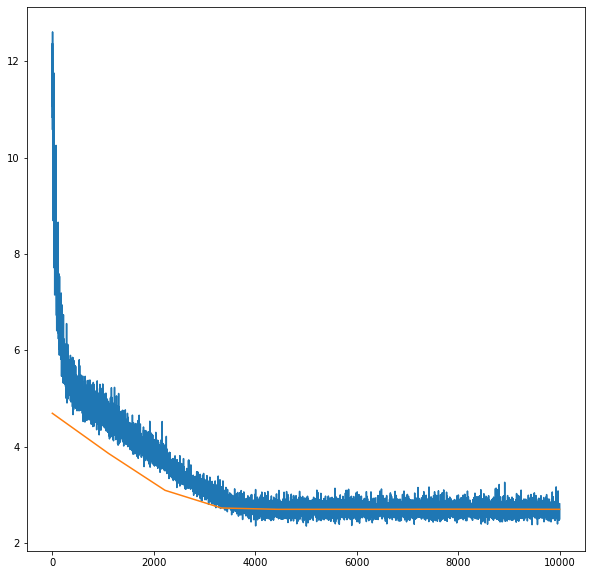

In [9]:
N = int(1e5)
M = int(1e5)
n_batch = 100
n_epochs = 10

eig, info = BED_class.calculate_eig(
    design=['1', '2'],
    method='variational_marginal',
    method_kwargs=
    {'guide': GMM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
     'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': None,
     'scheduler_kwargs': {},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'disable_tqdm': False
     }
)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['train_loss'])),
        info['train_loss'], label='train loss')
        
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['test_loss'])),
        info['test_loss'], label='test loss')

plt.show()

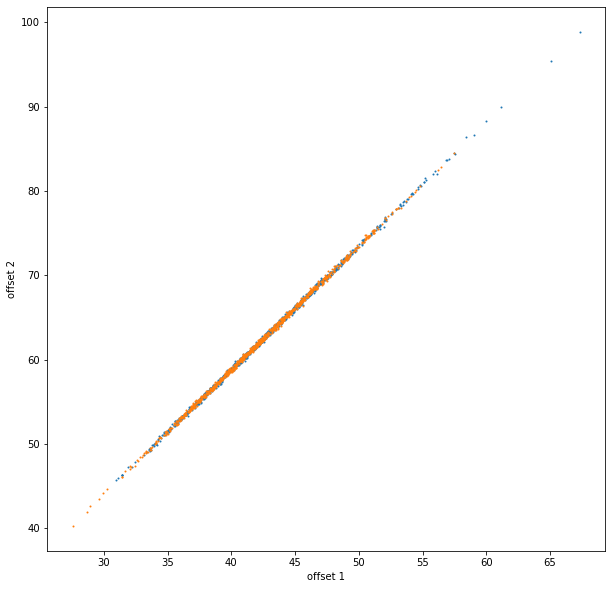

In [10]:
noisy_data = BED_class.get_noisy_data(['1', '2'], n_samples=1000)
guide_samples = info['guide']().sample(torch.Size([1000]))

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(noisy_data[:, 0], noisy_data[:, 1], s=1)
ax.scatter(guide_samples[:, 0], guide_samples[:, 1], s=1)

ax.set_xlabel('offset 1')
ax.set_ylabel('offset 2')

# ax.set_xlim(0.0, 1.0)
# ax.set_ylim(0.3, 1.0)

plt.show()

In [11]:
print(list((info['guide'].parameters())))

[Parameter containing:
tensor([1.5235], requires_grad=True), Parameter containing:
tensor([[-0.0246, -0.0230]], requires_grad=True), Parameter containing:
tensor([[-0.0135, -3.7117]], requires_grad=True), Parameter containing:
tensor([[0.9859]], requires_grad=True)]
